# 랜덤포레스트_연습

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
#한글 폰트 적용
matplotlib.rc("font", family ="Malgun Gothic")

# Step 1 데이터 구성하기

In [3]:
df_raw = pd.read_csv("./HMEQ.csv", engine = "python")
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [4]:
#결측치 확인
df_raw.isnull().sum(axis=0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [5]:
#JOB 변수의 결측치는 "other"로 대체, inplace : fillna 함수 적용후 df_raw 데이터에 저장, False면 저장 안함
df_raw["JOB"].fillna("Other", inplace = True)
#숫자혀 변수의 결측치는 해당 변수의 평균값 입력 : df_raw.mean() 각 변수별 평균 계산 후 결측치 대체
df_raw.fillna(df_raw.mean(), inplace = True)

In [6]:
# 더미변수 생성
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [7]:
df_raw_y = df_raw_dummy["BAD"]
df_raw_x = df_raw_dummy.drop("BAD", axis =1, inplace=False)

In [8]:
# train_test_split(데이터, test_size = test 데이터 비율, random_state :랜덤)
#데이터 구성하기
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.3, random_state=1234)
print("train data X size: {}". format(df_train_x.shape))
print("train data Y size: {}". format(df_train_y.shape))
print("test data X size: {}". format(df_test_x.shape))
print("test data Y size: {}". format(df_test_y.shape))

train data X size: (2623, 18)
train data Y size: (2623,)
test data X size: (1125, 18)
test data Y size: (1125,)


# Step 2 모델생성

In [9]:
# 기본 옵션으로 모델 생성
rf_uncustomized = RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

#train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))

#test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set: 0.992
Accuracy on test set: 0.944


/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [10]:
rf_uncustomized

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

### step 2 모델 paramter 조정
- n_estimators: 트리 수 변경에 따른 모델 성능

In [11]:
# 모델 parameter 조정 n_extimators : 트리수 변경에 따른 모델 성능

# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy=[]
#n_estimators : 트리수 변경: 1~150
para_n_tree = [n_tree*10 for n_tree in range(1,16)] # *참조: para_n_tree [10,20,30,...,150]

for v_n_estimators in para_n_tree:
    rf = RandomForestClassifier(n_estimators = v_n_estimators, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))

# 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["n_estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

#모델 정확도 확인
df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.992,0.944
1,20,0.999,0.943
2,30,0.999,0.942
3,40,1.000,0.946
4,50,1.000,0.944
5,60,1.000,0.948
6,70,1.000,0.947
7,80,1.000,0.947
8,90,1.000,0.946
9,100,1.000,0.946


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


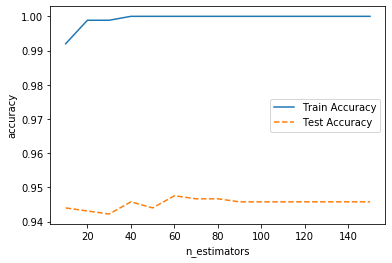

In [12]:
# 모델 정확도 그래프 확인
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("n_estimators"); plt.ylabel("accuracy")
plt.legend()

### n_estimators: 트리 수 변경에 따른 모델 
- oob error 변화

In [13]:
#error 저장 리스트
oob_error = []

for v_n_estimator in range(1, 151):
    rf = RandomForestClassifier(n_estimators = v_n_estimator, oob_score = True, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    oob_error.append(1-rf.oob_score_)


/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not hav

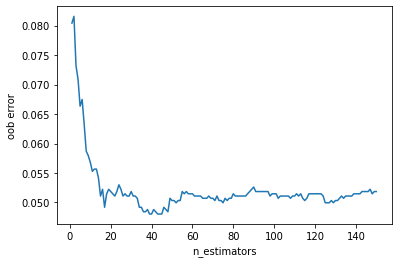

In [14]:
#그래프로 표현
plt.plot(range(1,151), oob_error)
plt.ylabel("oob error")
plt.xlabel("n_estimators")

#트리 수 지정
n_estimators = 100

### max_depth: 최대 깊이 변경에 따른 모델 성능

In [15]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy=[]
# max_depth: 최대 깊이 변경 
para_depth = [depth for depth in range(1,11)] # *참조: para_depth: [1,2,3,...,10]

for v_max_depth in para_depth:
    rf = RandomForestClassifier(max_depth = v_max_depth , n_estimators = 100, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["n_estimators"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

#모델 정확도 확인
df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.992,0.944
1,20,0.999,0.943
2,30,0.999,0.942
3,40,1.000,0.946
4,50,1.000,0.944
5,60,1.000,0.948
6,70,1.000,0.947
7,80,1.000,0.947
8,90,1.000,0.946
9,100,1.000,0.946


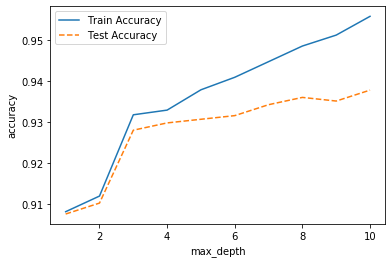

In [16]:
# 모델 정확도 그래프 확인
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("max_depth"); plt.ylabel("accuracy")
plt.legend()

#최대 깊이 지정
max_depth = 4

### min_samples_split: 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [17]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy=[]
# min_sample_split:분리 노드의 최소 자료 수
para_split = [n_split*10 for n_split in range(1,11)] #

for v_min_samples_split in para_split:
    rf = RandomForestClassifier(min_samples_split = v_min_samples_split, max_depth = 4 , n_estimators = 100, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

#모델 정확도 확인
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.933,0.929
1,20,0.933,0.929
2,30,0.932,0.929
3,40,0.933,0.929
4,50,0.932,0.929
5,60,0.932,0.929
6,70,0.932,0.929
7,80,0.932,0.928
8,90,0.932,0.928
9,100,0.932,0.928


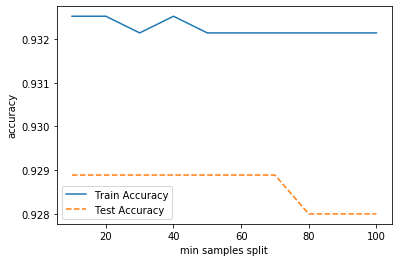

In [18]:
# 모델 정확도 그래프 확인
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min samples split"); plt.ylabel("accuracy")
plt.legend()

In [19]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy=[]
# min_sample_split:분리 노드의 최소 자료 수
para_leaf = [n_leaf*10 for n_leaf in range(1,11)] #

for v_min_samples_leaf in para_leaf:
    rf = RandomForestClassifier(min_samples_leaf = v_min_samples_leaf, 
                                max_depth = 4 , n_estimators = 100, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesleaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

#모델 정확도 확인
df_accuracy_leaf.round(3)

,MinSamplesleaf,TrainAccuracy,TestAccuracy
0,10,0.930,0.928
1,20,0.927,0.925
2,30,0.927,0.924
3,40,0.920,0.916
4,50,0.908,0.908
5,60,0.908,0.908
6,70,0.908,0.908
7,80,0.908,0.908
8,90,0.908,0.908
9,100,0.908,0.908


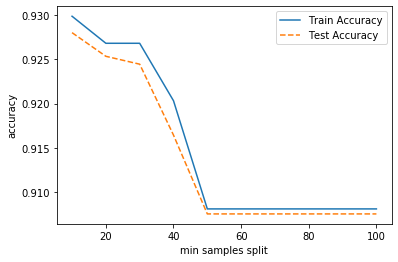

In [20]:
# 모델 정확도 그래프 확인
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min samples split"); plt.ylabel("accuracy")
plt.legend()

# Step3 결론 도출

In [21]:
#최종모델
rf_final = RandomForestClassifier(min_samples_leaf=20, max_depth = 4, n_estimators = 100, random_state=1234)
rf_final.fit(df_train_x, df_train_y)
#평가
y_pred = rf_final.predict(df_test_x)

#train 데이터 셋 정확도
print("Accuracy on training set: {0:.3f}\n".format(rf_final.score(df_train_x, df_train_y)))
#test 데이터 셋 정확도
print("Accuracy on test set: {0:.3f}\n".format(rf_final.score(df_test_x, df_test_y)))
#confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set: 0.927

Accuracy on test set: 0.925

Confusion matrix: 
[[1021    0]
 [  84   20]]


In [22]:
#변수명
v_feature_name = df_train_x.columns

# tree.teature_importances_로 설명 변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["importance"] = rf_final.feature_importances_

#df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values("importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,importance
9,DEBTINC,0.475
5,DELINQ,0.175
4,DEROG,0.066
6,CLAGE,0.061
7,NINQ,0.058
8,CLNO,0.051
0,LOAN,0.039
2,VALUE,0.027
3,YOJ,0.014
1,MORTDUE,0.013


Text(0, 0.5, 'variables')

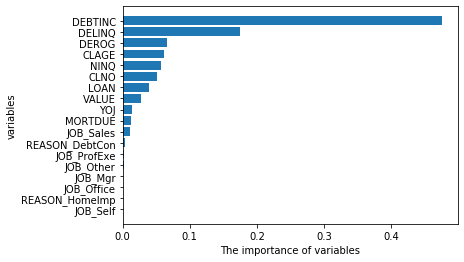

In [23]:
#설명변수 중요도 그래프
#중요도가 높은 변수를 상위에 그림.
df_importance.sort_values("importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("The importance of variables")
plt.ylabel("variables")

In [24]:
estimator = RandomForestClassifier(n_estimators=100, random_state=1234)
# 구하고자 하는 parameter와 범위
param_grid = {"max_depth":para_depth, 
              "min_samples_leaf":para_leaf}

# 정확도가 높은 최적 parameter 찾기
grid_rf = GridSearchCV(estimator, param_grid, scoring="accuracy", n_jobs=-1)
grid_rf.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_rf.best_estimator_))
print("\nbest parameter:\n{}".format(grid_rf.best_params_))
print("\nbest score:\n{}".format(grid_rf.best_score_.round(3)))

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best estimator model: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

best parameter:
{'max_depth': 9, 'min_samples_leaf': 10}

best score:
0.928
